# Mass balance type intercomparison with one flowline for all reference glaciers

In [1]:
import numpy as np
import netCDF4
import oggm
import matplotlib.pyplot as plt

from oggm.core.massbalance import MassBalanceModel
# necessary to import RandomMAssBalance and ConstantMassBalance for modified MultipleFlowlineModel
from oggm.core.massbalance import RandomMassBalance, ConstantMassBalance

from oggm import cfg
from oggm.cfg import SEC_IN_YEAR


from scipy.interpolate import interp1d
from scipy import optimize as optimization
# Locals
from oggm.cfg import SEC_IN_YEAR, SEC_IN_MONTH
from oggm.utils import (SuperclassMeta, lazy_property, floatyear_to_date,
                        date_to_floatyear, monthly_timeseries, ncDataset,
                        tolist, clip_min, clip_max, clip_array)
from oggm.exceptions import InvalidWorkflowError, InvalidParamsError

import scipy
import scipy.stats as stats
from scipy.optimize import minimize
from oggm import cfg, utils, workflow, tasks
from oggm.core.massbalance import LinearMassBalance
from oggm.core import climate
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import os

# import the new models
from mbmod_daily_oneflowline import process_era5_daily_data, mb_modules, BASENAMES
from help_func import compute_stat, minimize_bias, optimize_std_quot_brentq

In [2]:
SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 24
plt.rc('figure',figsize=(20,10))
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
# take only Alpine reference glaciers, all reference glaciers does not work because of init_glacier_directories ...
rgi_version = '61'
#rgi_region = '11'  # Region Central Europe
#path = utils.get_rgi_region_file(rgi_region, version=rgi_version)
#rgidf = gpd.read_file(path)

df, _ = utils.get_wgms_files()
# if for all 
ref_glaciers = df[df['RGI_REG']=='11']['RGI{}0_ID'.format(rgi_version[0])] #[df['RGI_REG']=='11']
# ref_glaciers = df['RGI{}0_ID'.format(rgi_version[0])] #[df['RGI_REG']=='11']

df = utils.get_rgi_glacier_entities(ref_glaciers.values) #, 'RGI-60-11.01238'])

cfg.initialize()
working_dir = '/home/lilianschuster/Schreibtisch/PhD/oggm_files/oneFlowline'
# this needs to be changed if working on another computer
if not os.path.exists(working_dir):
    working_dir = utils.gettempdir(dirname='OGGM_mb_type_intercomparison', reset=True)
    
cfg.PATHS['working_dir'] = working_dir

cfg.PARAMS['baseline_climate'] = 'ERA5_daily'
base_url = 'https://cluster.klima.uni-bremen.de/~fmaussion/gdirs/prepro_l2_202010/elevbands_fl'
gdirs = workflow.init_glacier_directories(df, from_prepro_level=2, prepro_border=40, 
                                          prepro_base_url=base_url, prepro_rgi_version='62')

---

In [5]:
# create a pandas dataframe
# this is not the best way to do this:
# better would be a xarray dataset with mb_type+grad & rgi_id as dimensions and DDF_opt and stats(RMSD,bias,rcor,std_quot) as variables 

pd_mb_data = pd.DataFrame(df['RGIId'].values)
pd_mb_data.index = pd_mb_data[0]

for mb_type in ['mb_monthly', 'mb_daily', 'mb_real_daily']:
    for grad in ['cte', 'var_an_cycle']:
        pd_mb_data['DDF_opt_{}_{}'.format(mb_type, grad)] = np.NaN
        pd_mb_data['stats_{}_{}'.format(mb_type, grad)] = np.NaN


### compute how well the mass balance is modelled and plot this for all Alpine reference glaciers

save the optimised DDF, statistics & ...  in pd_mb_data


In [13]:
run = False
if run:
    pf = 2.5
    N= 5000
    loop = False
    for gd in gdirs:
        try:
            # need ERA5dr climate if not mb_real_daily 
            cfg.PARAMS['baseline_climate'] = 'ERA5dr'
            oggm.shop.ecmwf.process_ecmwf_data(gd, dataset = 'ERA5dr')
            mbdf = gd.get_ref_mb_data()
            h, w = gd.get_inversion_flowline_hw()
            plt.figure(figsize=(24,15))
            plt.plot(mbdf.index,mbdf.ANNUAL_BALANCE, label = 'observed', color = 'black', lw = 2)
            for mb_type in ['mb_monthly', 'mb_daily']: 
                for grad in ['cte', 'var_an_cycle']:        

                    pd_mb_data.loc[gd.rgi_id, 'DDF_opt_{}_{}'.format(mb_type, grad)] = scipy.optimize.brentq(minimize_bias,1,10000, xtol = 0.01,
                                                args=(mb_type, grad, gd, N, 2.5, loop, False) )
                    gd_mb = mb_modules(gd, pd_mb_data.loc[gd.rgi_id, 'DDF_opt_{}_{}'.format(mb_type, grad)],
                                       mb_type=mb_type,     grad_type=grad, prcp_fac = pf, loop = loop) 
                    mb_specific = gd_mb.get_specific_mb(heights = h, widths = w,  year = mbdf.index.values)
                    label_part1 = 'modeled {} {} gradient: '.format(mb_type, grad)
                    pd_mb_data.loc[gd.rgi_id,'stats_{}_{}'.format(mb_type, grad)] = [compute_stat(mb_specific=mb_specific, mbdf=mbdf, return_dict = True, return_plot = label_part1)]

            # need ERA5_daily climate for mb_real_daily 
            cfg.PARAMS['baseline_climate'] = 'ERA5_daily'
            process_era5_daily_data(gd)
            for mb_type in ['mb_real_daily']:
                for grad in ['cte', 'var_an_cycle']:   
                    pd_mb_data.loc[gd.rgi_id, 'DDF_opt_{}_{}'.format(mb_type, grad)] = scipy.optimize.brentq(minimize_bias,1,10000, xtol = 0.01,
                                                args=(mb_type, grad, gd, N, 2.5, loop, False) )
                    gd_mb = mb_modules(gd, pd_mb_data.loc[gd.rgi_id, 'DDF_opt_{}_{}'.format(mb_type, grad)],
                                       mb_type=mb_type,     grad_type=grad, prcp_fac = pf, loop = loop) 
                    mb_specific = gd_mb.get_specific_mb(heights = h, widths = w,  year = mbdf.index.values)
                    label_part1 = 'modeled {} {} gradient: '.format(mb_type, grad)
                    pd_mb_data.loc[gd.rgi_id,'stats_{}_{}'.format(mb_type, grad)] = [compute_stat(mb_specific=mb_specific, mbdf=mbdf, return_dict = True, return_plot = label_part1)]



            plt.ylabel('SMB (kg m$^{-2}$ yr$^{-1}$)');

            plt.xlabel('year')
            plt.title(gd.rgi_id)
            plt.legend()

            plt.savefig('./figures_alps_indiv/mb_one_flowline_{}_N_{}.pdf'.format(gd.rgi_id,N))
            plt.close()
        except:
            print(gd.rgi_id)
            plt.close()

    pd_mb_data.to_csv('stats_Alps_6mb_models_N_{}_with_mean_an_cycle.csv'.format(N), index = False)


In [9]:
pd_mb_data = pd.read_csv('stats_Alps_6mb_models_N_{}_with_mean_an_cycle.csv'.format(N), index_col = '0')

pd_mb_data


,DDF_opt_mb_monthly_cte,stats_mb_monthly_cte,DDF_opt_mb_monthly_var_an_cycle,stats_mb_monthly_var_an_cycle,DDF_opt_mb_daily_cte,stats_mb_daily_cte,DDF_opt_mb_daily_var_an_cycle,stats_mb_daily_var_an_cycle,DDF_opt_mb_real_daily_cte,stats_mb_real_daily_cte,DDF_opt_mb_real_daily_var_an_cycle,stats_mb_real_daily_var_an_cycle
0,,,,,,,,,,,,
RGI60-11.00002,162.336704,"{'RMSD': 85.2026731783895, 'bias': 6.181008234...",131.713232,"{'RMSD': 82.26456680369107, 'bias': 0.00014996...",142.439549,"{'RMSD': 80.32073342553144, 'bias': -0.0450286...",117.413726,"{'RMSD': 86.10870582635012, 'bias': -0.0384542...",144.316305,"{'RMSD': 75.27244104537084, 'bias': 0.00027017...",109.259364,"{'RMSD': 93.6000405170309, 'bias': 0.000180391..."
RGI60-11.00012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RGI60-11.00073,347.380969,"{'RMSD': 3.8070075106588774e-05, 'bias': -3.80...",234.331659,"{'RMSD': 5.1658128882081655e-05, 'bias': -5.16...",256.319129,"{'RMSD': 0.05124615345403072, 'bias': -0.05124...",185.251292,"{'RMSD': 0.04345412340001076, 'bias': -0.04345...",266.959851,"{'RMSD': 0.00021377356313223572, 'bias': 0.000...",188.850426,"{'RMSD': 9.349113815915189e-05, 'bias': 9.3491..."
RGI60-11.00080,249.528927,"{'RMSD': 117.42395604323033, 'bias': -6.042995...",203.476933,"{'RMSD': 111.11206103101148, 'bias': 5.7973386...",204.861811,"{'RMSD': 106.50391784661221, 'bias': -0.061531...",171.790798,"{'RMSD': 104.62658304140328, 'bias': -0.053320...",208.068058,"{'RMSD': 96.99937430858677, 'bias': 7.73478047...",163.033301,"{'RMSD': 96.27093179630721, 'bias': 0.00013408..."
RGI60-11.00106,244.362436,"{'RMSD': 123.23629006690192, 'bias': -9.806697...",212.695607,"{'RMSD': 112.92882935724548, 'bias': 6.9453356...",205.871378,"{'RMSD': 104.46459578093757, 'bias': -0.057242...",181.940511,"{'RMSD': 98.2260706828189, 'bias': -0.05214938...",206.106552,"{'RMSD': 97.96346965101718, 'bias': -4.2296311...",172.925847,"{'RMSD': 89.8592588269464, 'bias': 2.107506952..."
...,...,...,...,...,...,...,...,...,...,...,...,...
RGI60-11.03638,209.345509,"{'RMSD': 96.05522152511573, 'bias': 6.83266401...",184.240421,"{'RMSD': 89.85894816123741, 'bias': 7.80916446...",185.683121,"{'RMSD': 89.80801994749443, 'bias': -0.0507930...",165.123558,"{'RMSD': 85.6001868130294, 'bias': -0.04671352...",185.250596,"{'RMSD': 88.78081249811751, 'bias': 6.33201193...",156.057436,"{'RMSD': 82.24563966797747, 'bias': 3.77145316..."
RGI60-11.03643,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RGI60-11.03671,163.654858,"{'RMSD': 78.8962026941356, 'bias': -5.35172746...",148.889093,"{'RMSD': 78.35967775511905, 'bias': -0.0001157...",147.456474,"{'RMSD': 70.08490386745596, 'bias': -0.0402268...",134.980214,"{'RMSD': 70.3287075833161, 'bias': -0.03762276...",147.027413,"{'RMSD': 68.59258108116806, 'bias': -0.0002008...",128.823763,"{'RMSD': 68.63641834035748, 'bias': -2.9282897..."


In [10]:

# this is a bit complicated because the dict value entries were saved as string and not as dict type in pandas somehow
# therefore I need ast.literal_eval to read the csv file ... I will use xarray next time
import ast

def get_stats(stat = 'RMSD', mb_type = 'mb_daily', grad_type = 'cte'):
    stats = []
    for k in np.arange(len(pd_mb_data)):
        #print(k)
        #if np.isnan(pd_mb_data['stats_mb_daily_cte'].values[k]):
        #    print('x')
        #    RMSD.append(np.NaN)
        stats_type = 'stats_{}_{}'.format(mb_type,grad_type)
        try:
            if type(pd_mb_data[stats_type].values[k]) == list:
                stats.append(pd_mb_data[stats_type].values[k][0][stat])
            else:
                stats.append(pd_mb_data[stats_type].values[k][stat])

        except:
            #RMSD.append(np.NaN)
            pass
        try:
            if type(ast.literal_eval(pd_mb_data[stats_type].values[k])) == list:

                stats.append(ast.literal_eval(pd_mb_data[stats_type].values[k])[0][stat])
                # print('y')

            else:
                stats.append(ast.literal_eval(pd_mb_data[stats_type].values[k])[stat])

        except:
            #RMSD.append(np.NaN)
            pass
    return np.array(stats)[~np.isnan(stats)]

# Plots of model performance statistics for all Alpine reference glaciers (without cross validation)

### 1. DDF values

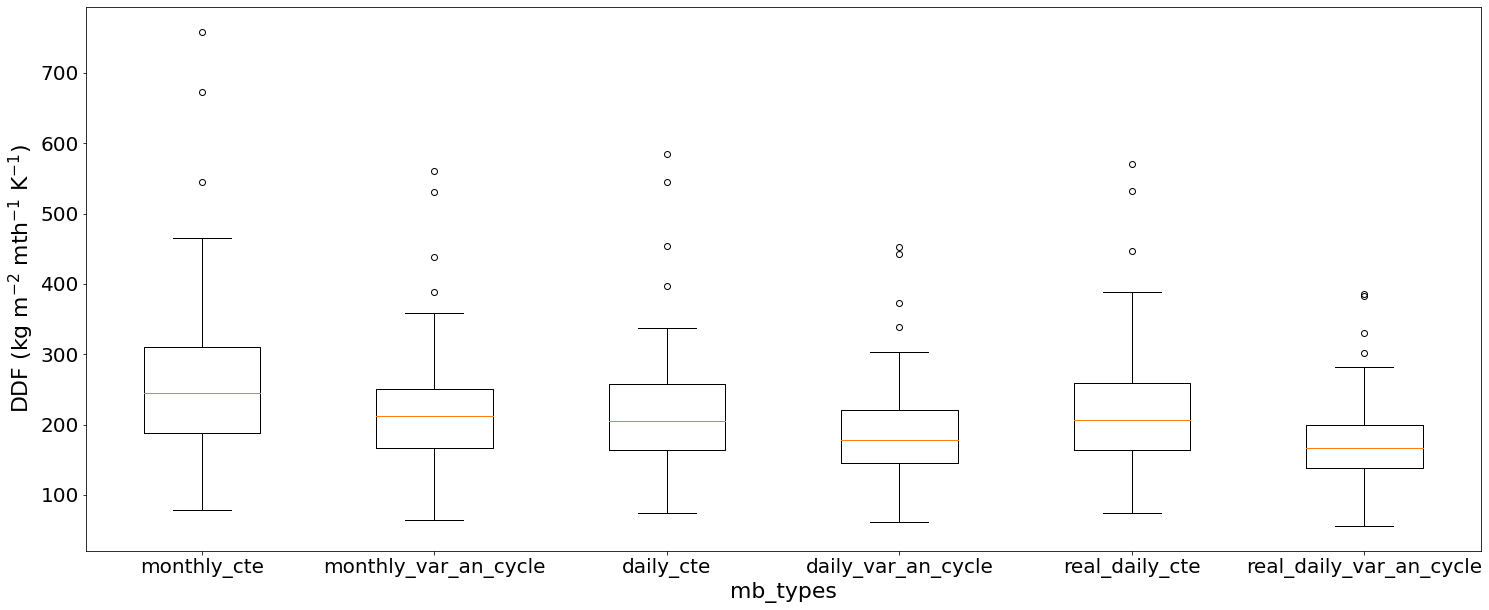

In [11]:
plt.figure(figsize=(25,10))
li_plot = []
li_label = []
for mb_type in ['mb_monthly','mb_daily', 'mb_real_daily']: #,'mb_real_daily']:
        for grad in ['cte','var_an_cycle']:
            li_plot.append(pd_mb_data['DDF_opt_{}_{}'.format(mb_type,grad)][~np.isnan(pd_mb_data['DDF_opt_{}_{}'.format(mb_type,grad)])])
            li_label.append(mb_type[3:]+'_'+grad)
plt.boxplot(li_plot, labels =li_label)
plt.ylabel('DDF (kg m$^{-2}$ mth$^{-1}$ K$^{-1}$)') 
plt.xlabel('mb_types')
plt.savefig('./figures_alps/alps_6mbtypes_DDF.pdf')

- a more complicated mass balance module resutls in DDF that are lower 
    - if not a cte gradient is used anymore, the lapse rate is different resulting in smaller DDFs
    - if std (daily_cte) or real daily temperature data are used, the DDF is smaller because even for months with no temperatures above the threshold, 
        melting occurs ... 

### 2. Performance measures

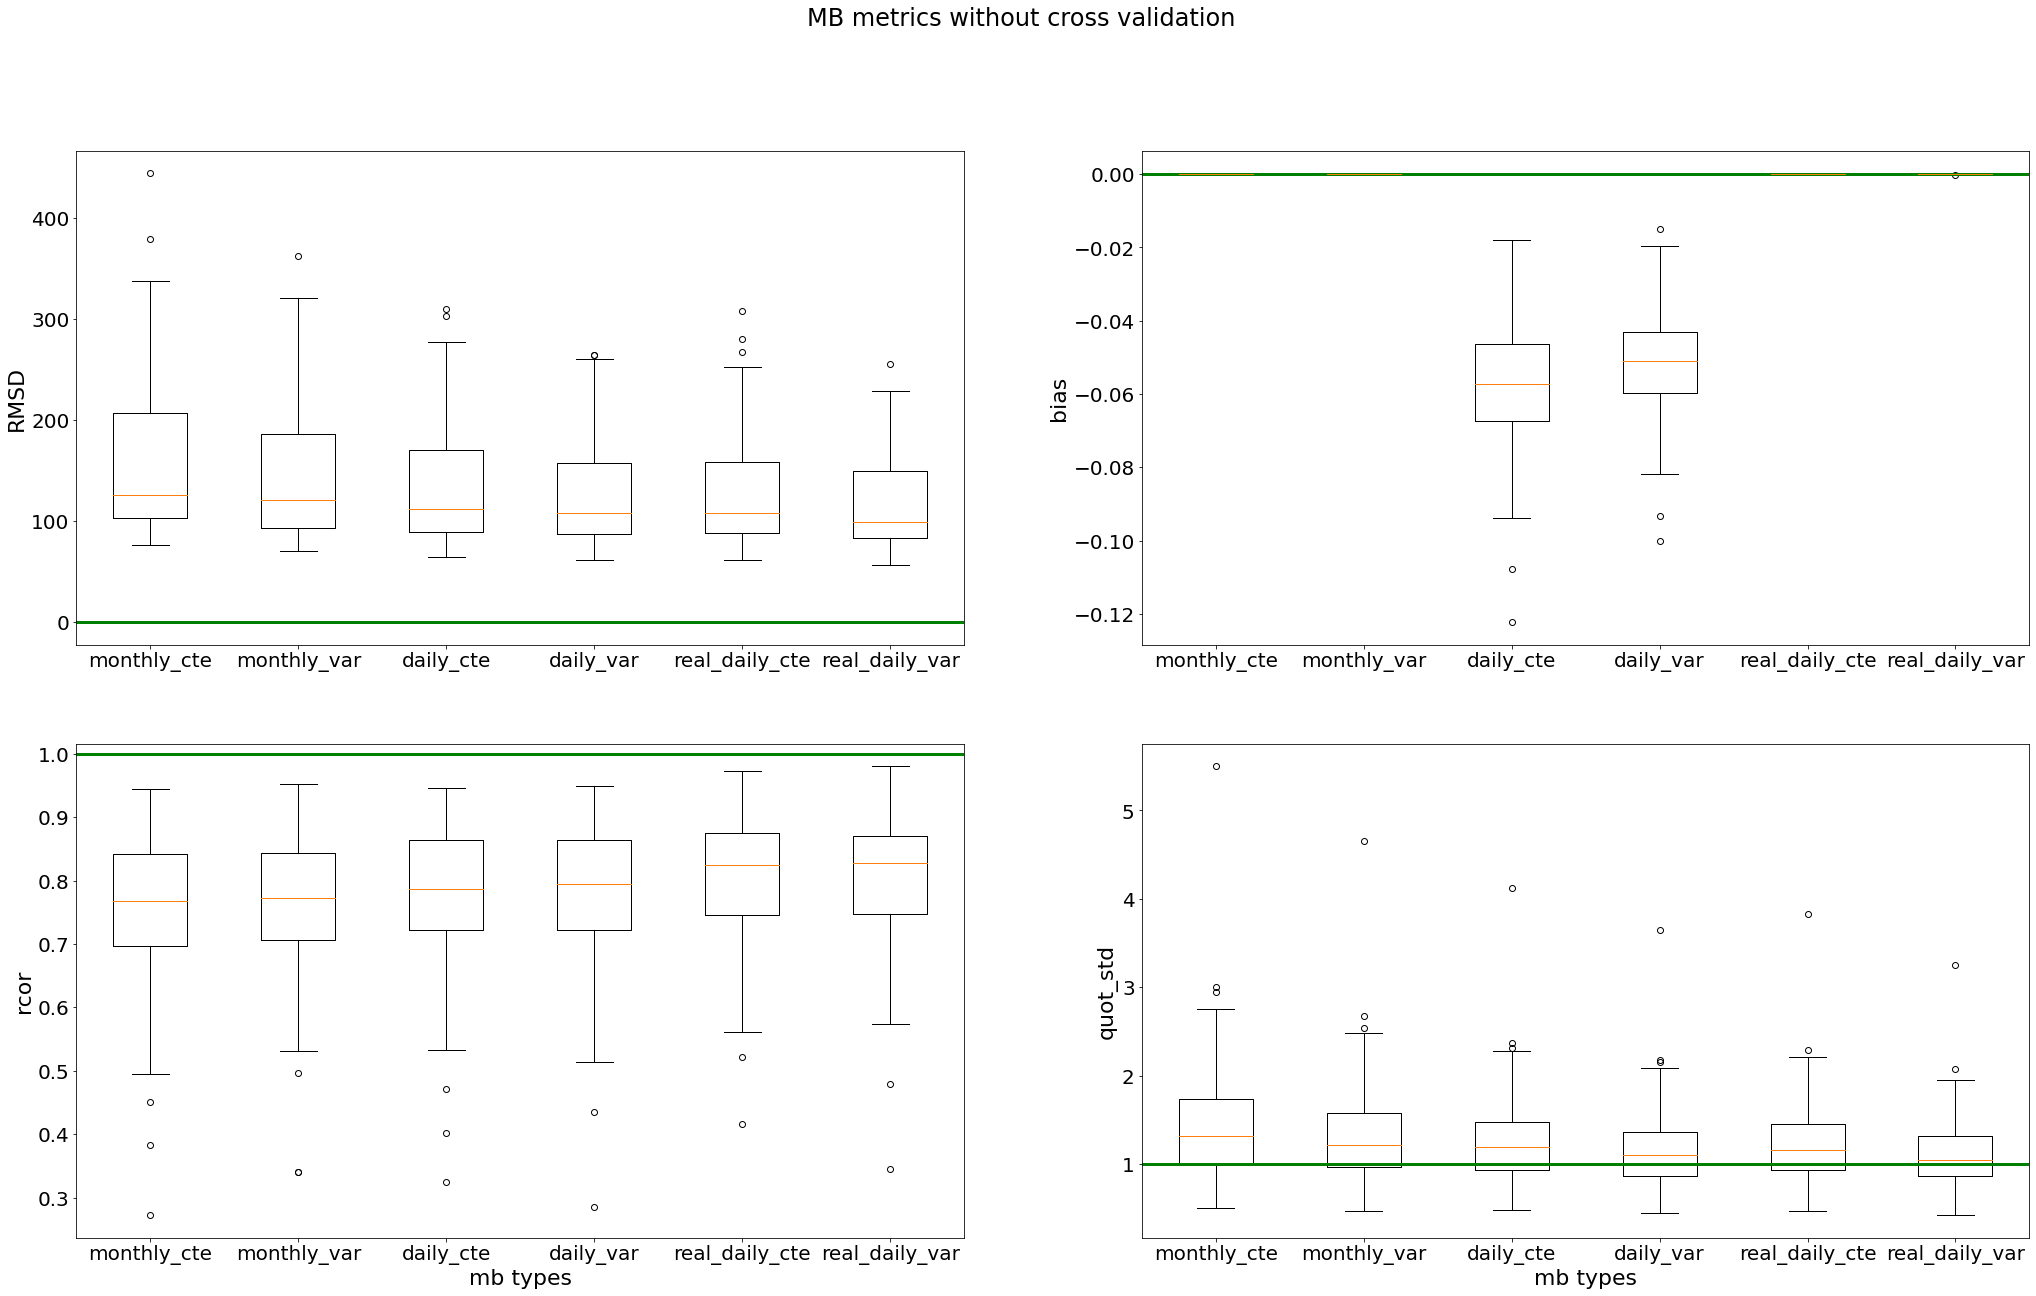

In [12]:
plt.figure(figsize=(35,20))
plt.suptitle('MB metrics without cross validation')
for f, stats_type in enumerate(['RMSD','bias','rcor','quot_std']):
    plt.subplot(2,2,f+1)
    plt.boxplot([np.array(get_stats(stat = stats_type, mb_type = 'mb_monthly', grad_type = 'cte')),
                np.array(get_stats(stat = stats_type, mb_type = 'mb_monthly', grad_type = 'var_an_cycle')),
                np.array(get_stats(stat = stats_type, mb_type = 'mb_daily', grad_type = 'cte')),
                np.array(get_stats(stat = stats_type, mb_type = 'mb_daily', grad_type = 'var_an_cycle')),
                np.array(get_stats(stat = stats_type, mb_type = 'mb_real_daily', grad_type = 'cte')),
                np.array(get_stats(stat = stats_type, mb_type = 'mb_real_daily', grad_type = 'var_an_cycle')),
                ],
                labels = ['monthly_cte', 'monthly_var','daily_cte', 'daily_var', 'real_daily_cte', 'real_daily_var'])
    plt.ylabel(stats_type)
    plt.xticks()
    if f >1:
        plt.xlabel('mb types')
    #if stats_type =='RMSD':
    #    plt.ylim([-10,500])
    #if stats_type =='std_quot':
    #    plt.ylim([-0.1,4])
    if (stats_type =='RMSD') or (stats_type =='bias'):
        plt.axhline(0, lw=3, color='green')
    if (stats_type =='rcor') or (stats_type =='quot_std'):
        plt.axhline(1, lw=3, color='green')
plt.savefig('./figures_alps/stats_one_flowline_N_{}_59Alps_refglaciers_var_6mb_types_with_mean_an_cycle.pdf'.format(N))

- more complex mb modules seem to perform better (when no cross-validation used)
- if N is increased, the bias for mb_daily would go more to zero (but the bias does not need to be calibrated that exactly... and a smaller N is much faster)
